In [1]:
import scanpy as scp
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import numpy as np
import scipy.stats as stats
import scipy.sparse as sparse
import scipy as spy
import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import gget
import pynndescent as pynn
import re
from utils import functions as f
from time import time
from sklearn.cluster import DBSCAN
import json
import kmapper as km
import networkx as nx
import seaborn as sns
from adjustText import adjust_text

In [2]:
data = scp.read_h5ad('./data_8_25_23.h5ad') 
count = scp.read_h5ad('./patelData/patelOlahCountWithOriginalClusters.h5ad') 
genes = data.var.index.tolist()
ikeep = data.obs.index.tolist()
count = count[ikeep,genes]

In [3]:
data.obs['leiden'] = data.obs['leiden'].astype('int').astype('category')
scp.tl.rank_genes_groups(data, groupby = 'leiden')

geneFrac = []
for i in range(9):
    cells = data.obs.query(f'leiden == {i}').index.tolist()
    datRed = count[cells,:].X
    tot = datRed.shape[0]
    nonzero = np.count_nonzero(datRed, axis=0)
    geneFrac.append(nonzero/tot)
    
frac = pd.DataFrame(geneFrac, index = [f'cluster {i}' for i in range(9)], columns=data.var.index).T


results = []
for j in range(9):    
    query = 'pvals_adj <= .05'
    df = scp.get.rank_genes_groups_df(data, group=str(j))
    df = df.join(frac.loc[:,f'cluster {j}'], on = 'names').query(query).rename(columns = {f'cluster {j}' : 'fraction'})
    df.to_csv(f'./diffExpNew/cluster_{j}_diffexp_no_filter.csv')
    results.append(df)

/Users/andrew/opt/miniconda3/envs/silly/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/andrew/opt/miniconda3/envs/silly/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/andrew/opt/miniconda3/envs/silly/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/andrew/opt/miniconda3/envs/silly/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/andrew/opt/miniconda3/envs/silly/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in

In [4]:
clust_names = ['cytokine', 'homeostatic', 'transitional', 'metabolically\nstagnant', 'exAM1', 'DAM', 'exAM2','iron-associated' ,'antigen\npresenting']

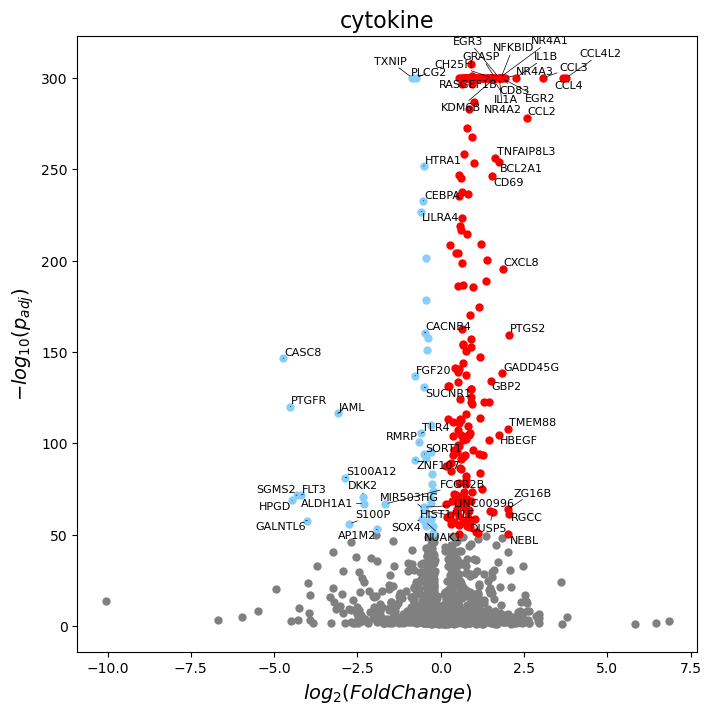

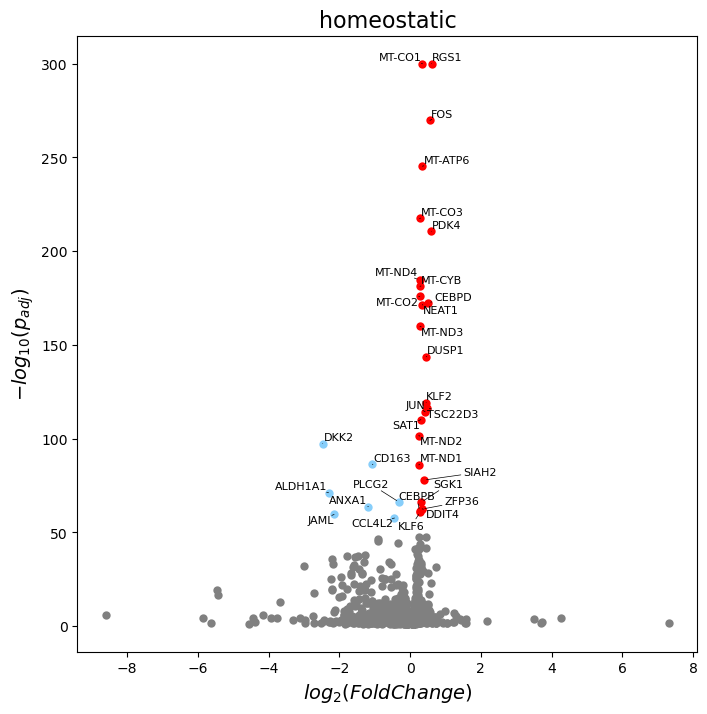

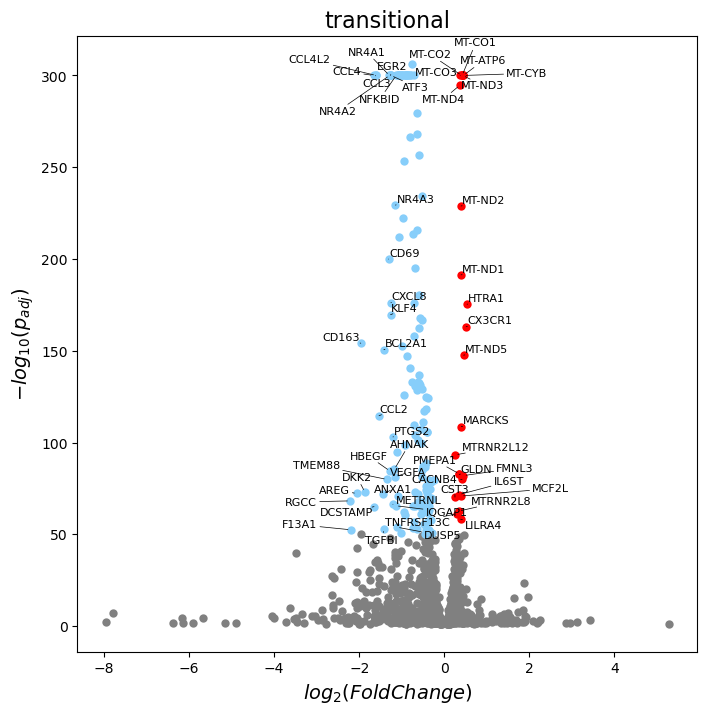

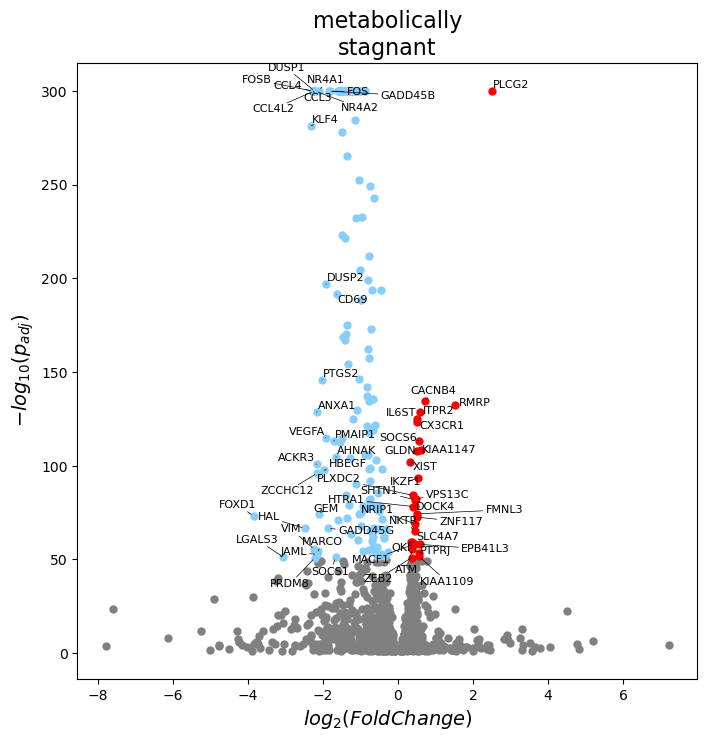

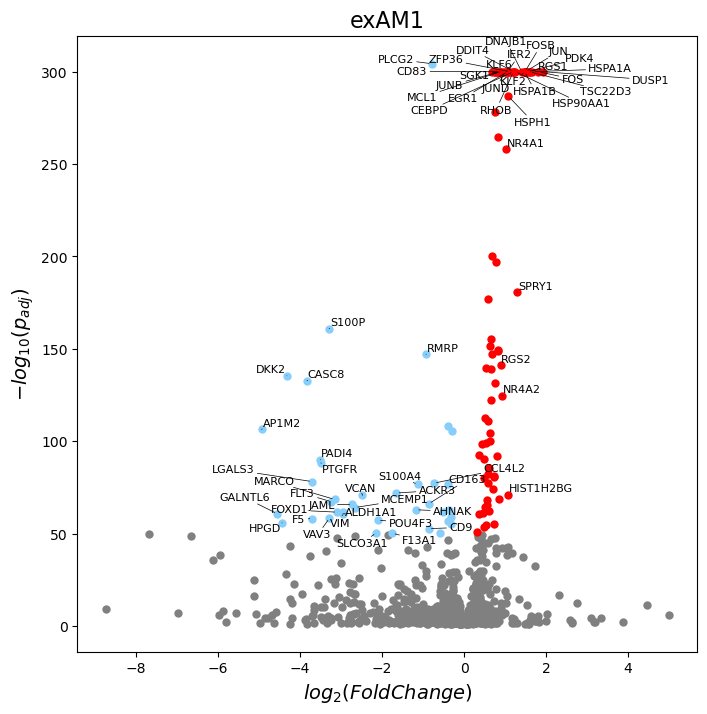

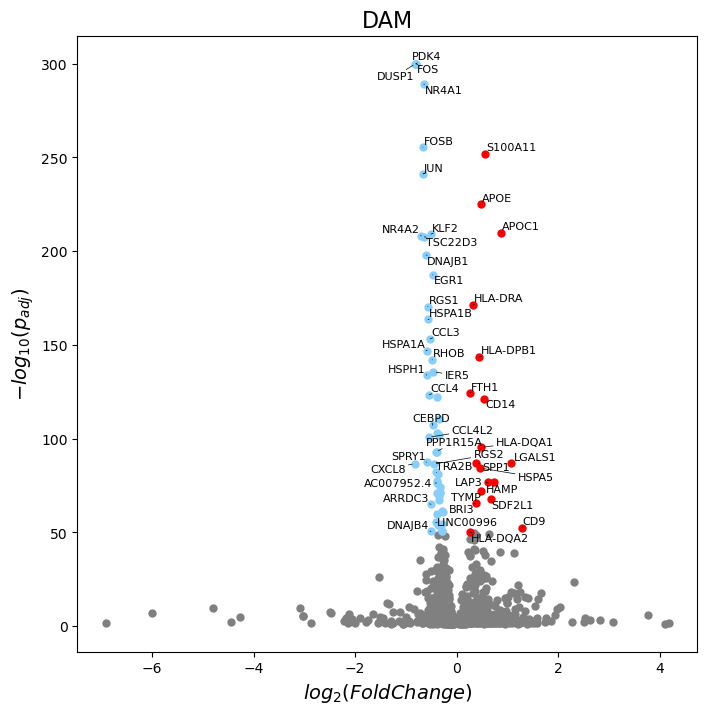

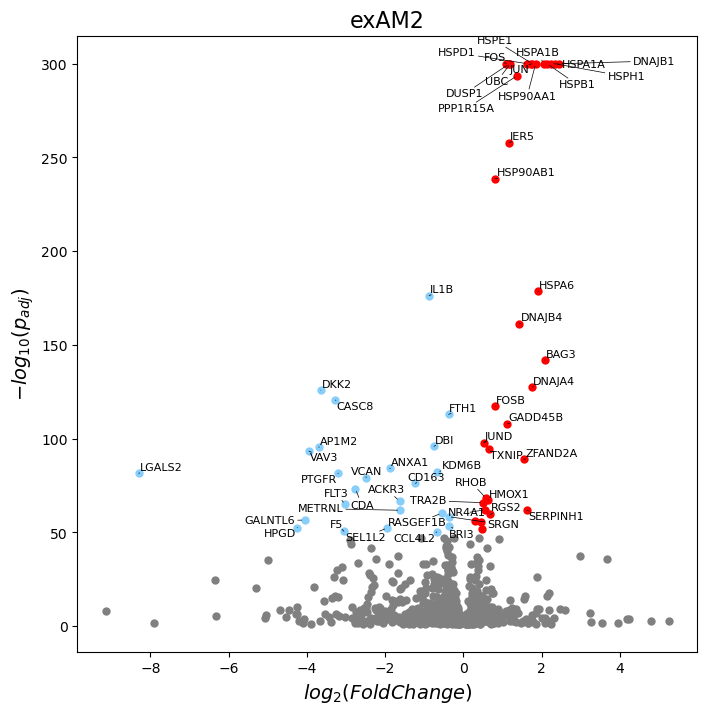

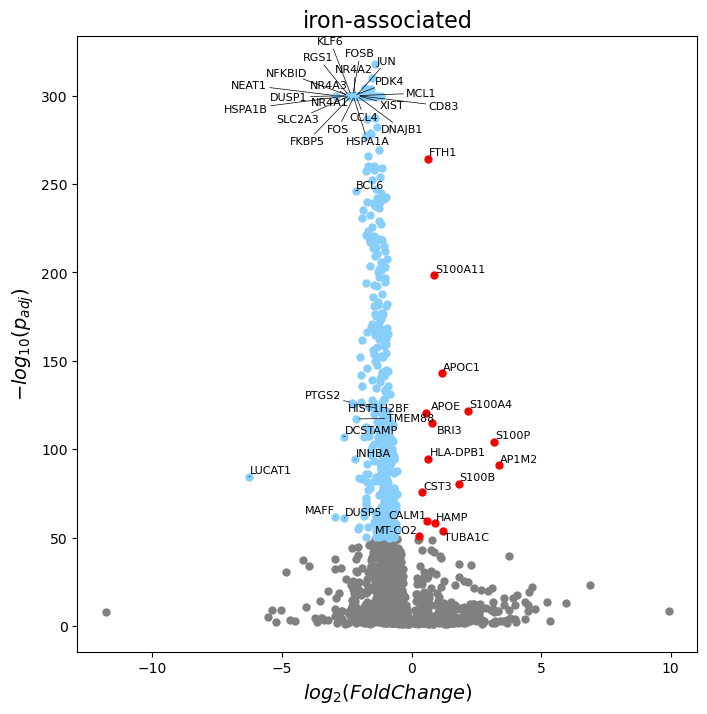

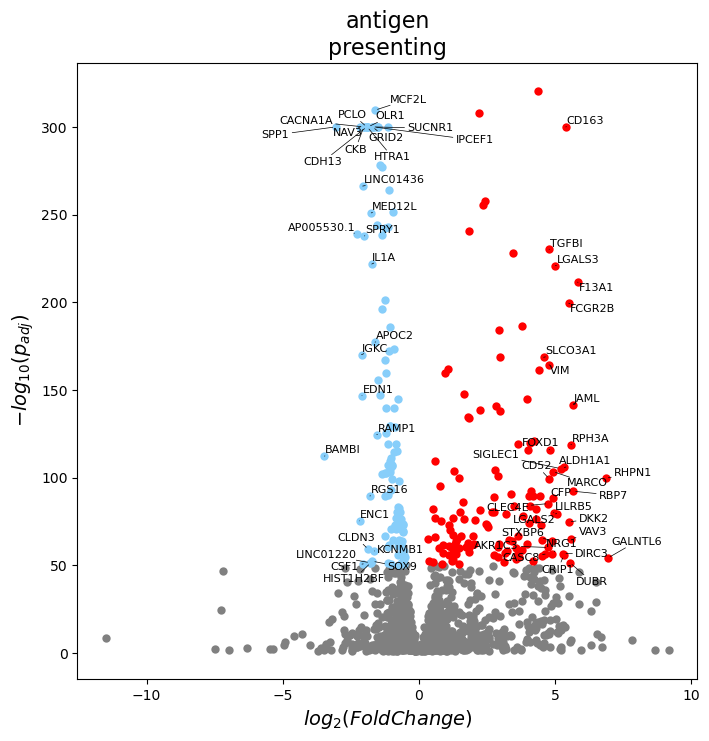

In [5]:
num = 30
for i, df in enumerate(results):
    df['pvals_adj'] = df['pvals_adj'].replace({0: 10**(-300)})
    plt.figure(figsize=(8,8))
    threshold = 10**(-50)
    xns, yns = df['logfoldchanges'][df['pvals_adj']>=threshold], -np.log10(df['pvals_adj'][df['pvals_adj']>=threshold])
    
    plt.scatter(xns, yns, c='grey', edgecolor=(1,1,1,0), label='Not Sig')
    xsU, ysU = df['logfoldchanges'][(df['pvals_adj']<threshold)&(df['logfoldchanges']>0)], -np.log10(df['pvals_adj'][(df['pvals_adj']<threshold)&(df['logfoldchanges']>0)])
    plt.scatter(xsU, ysU, c='r', edgecolor=(1,1,1,0), label='FDR<5%, upregulated')
    
    xsD, ysD = df['logfoldchanges'][(df['pvals_adj']<threshold)&(df['logfoldchanges']<0)], -np.log10(df['pvals_adj'][(df['pvals_adj']<threshold)&(df['logfoldchanges']<0)])
    plt.scatter(xsD, ysD, c='lightskyblue', edgecolor=(1,1,1,0), label='FDR<5%, downregulated')
    texts = []
    
    if len(xsU)>num:
        FC = [[i,np.abs(x)] if str(x) != 'nan' else [i,0] for i, x in zip(xsU.index,xsU)]
        FC.sort(key = f.Second, reverse=True)
        ind = [x[0] for x in FC[:num]]
        x_lab = [xsU[i] for i in ind if str(xsU[i]) != 'nan' ]
        y_lab = [ysU[i] for i in ind if str(ysU[i]) != 'nan' ]
        names = df.loc[ind,'names'].tolist()
        for x, y, l in zip(x_lab, y_lab, names):
            texts.append(plt.text(x, y, l, size=8))
    else: 
        for x, y, l in zip(xsU, ysU,df[(df['pvals_adj']<threshold)&(df['logfoldchanges']>0)]['names'].tolist()):
            texts.append(plt.text(x, y, l, size=8))
            
    if len(xsD)>num:
        FC = [[i,np.abs(x)] if str(x) != 'nan' else [i,0] for i, x in zip(xsD.index,xsD)]
        FC.sort(key = f.Second, reverse=True)
        ind = [x[0] for x in FC[:num]]
        x_lab = [xsD[i] for i in ind if str(xsD[i]) != 'nan' ]
        y_lab = [ysD[i] for i in ind if str(ysD[i]) != 'nan' ]
        names = df.loc[ind,'names'].tolist()
        for x, y, l in zip(x_lab, y_lab, names):
            texts.append(plt.text(x, y, l, size=8))
    else: 
        for x, y, l in zip(xsD, ysD,df[(df['pvals_adj']<threshold)&(df['logfoldchanges']<0)]['names'].tolist()):
            texts.append(plt.text(x, y, l, size=8))
#    plt.legend()
    plt.xlabel('$log_2(Fold Change)$', fontsize = 14)
    plt.ylabel('$-log_{10}(p_{adj})$',fontsize = 14)
    plt.title(clust_names[i], fontsize = 16)

    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    plt.savefig(f'./diffExpNew/volcano/volcano_clust_{i}_sc.png', dpi=300)
    plt.show()

In [18]:
df

,names,scores,logfoldchanges,pvals,pvals_adj,fraction
0,CCL3,191.503128,3.082639,0.000000e+00,1.000000e-300,0.977378
1,CCL4,175.344025,3.664926,0.000000e+00,1.000000e-300,0.967450
2,CCL4L2,153.863525,3.772251,0.000000e+00,1.000000e-300,0.931507
3,CD83,124.851807,1.834975,0.000000e+00,1.000000e-300,0.956014
4,SRGN,118.936607,1.277932,0.000000e+00,1.000000e-300,0.995099
...,...,...,...,...,...,...
1995,LILRA4,-32.809746,-0.582188,6.452895e-229,1.633644e-227,0.086842
1996,CEBPA,-33.230377,-0.525003,9.797566e-235,2.512196e-233,0.104688
1997,HTRA1,-34.736523,-0.514128,7.111143e-254,2.003139e-252,0.443635
1998,TXNIP,-43.903687,-0.859640,0.000000e+00,1.000000e-300,0.333417


In [21]:
df.loc[ind,:]

,names,scores,logfoldchanges,pvals,pvals_adj,fraction
1989,CASC8,-26.074575,-4.731618,1.569835e-148,2.854245e-147,0.000000
1986,PTGFR,-23.572838,-4.515081,5.324227e-122,8.128591e-121,0.000000
1969,HPGD,-17.784945,-4.458446,1.745038e-70,1.771612e-69,0.000000
1972,SGMS2,-18.151268,-4.314950,2.678282e-73,2.789877e-72,0.000000
1973,FLT3,-18.168404,-4.183809,1.768536e-73,1.861617e-72,0.000000
1960,GALNTL6,-16.288046,-4.000050,1.984163e-59,1.748161e-58,0.000000
1985,JAML,-23.200428,-3.089812,2.955326e-118,4.477766e-117,0.001257
1976,S100A12,-19.370253,-2.868093,5.722071e-83,6.393375e-82,0.001257
1958,S100P,-16.048700,-2.747814,1.574585e-57,1.345799e-56,0.000251
1971,DKK2,-18.047884,-2.330694,1.587727e-72,1.645313e-71,0.000000


In [233]:
tri_df.loc['APOE',:]

cluster0   -1
cluster1    0
cluster2    1
cluster3   -1
cluster4   -1
cluster5    1
cluster6   -1
cluster7    1
cluster8    0
Name: APOE, dtype: int64

In [216]:
results_sig = []
for i,df in enumerate(results):
    ddf = df.query('(pvals_adj <.001)&(fraction >= .5)')
    ddf.to_csv(f'./diffExpNew/sc_cluster_{i}.csv')
    results_sig.append(ddf)

In [217]:
genesUp=[]
genesDown=[]

genesUpFlat = []
genesDownFlat = []

for df in results_sig:
    up = df.query('fraction > .5 & logfoldchanges>0')['names'].tolist()
    down = df.query('fraction > .5 & logfoldchanges<0')['names'].tolist()
    genesUp.append(up)
    genesDown.append(down)
    genesUpFlat.extend(up)
    genesDownFlat.extend(down)
    
genesUpUnique = list(set(genesUpFlat)) 
counts = []

for g in genesUpUnique:
    c = genesUpFlat.count(g)
    counts.append([g,c])
    
counts.sort(key=f.Second, reverse = True)
concern = []
for c in counts:
    if c[1]>=4:
        concern.append(c[0])
        con = []
for c in concern:
    lst =  [genesDown.index(d) for d in genesDown if c in d ]
    con.append([c] + lst)
    
genesTot = list(set(genesUpFlat + genesDownFlat))

In [65]:
genes = pd.DataFrame(genesTot, columns = ['names'])
genes.to_csv('./gene_names_sc.csv')

In [218]:
tri = []
for up, down in zip(genesUp, genesDown):
    tri.append([1 if g in up else -1 if g in down else 0 for g in genesTot])
    
tri_df = pd.DataFrame(tri, index = [f'cluster{i}' for i in range(9)], columns= genesTot).T

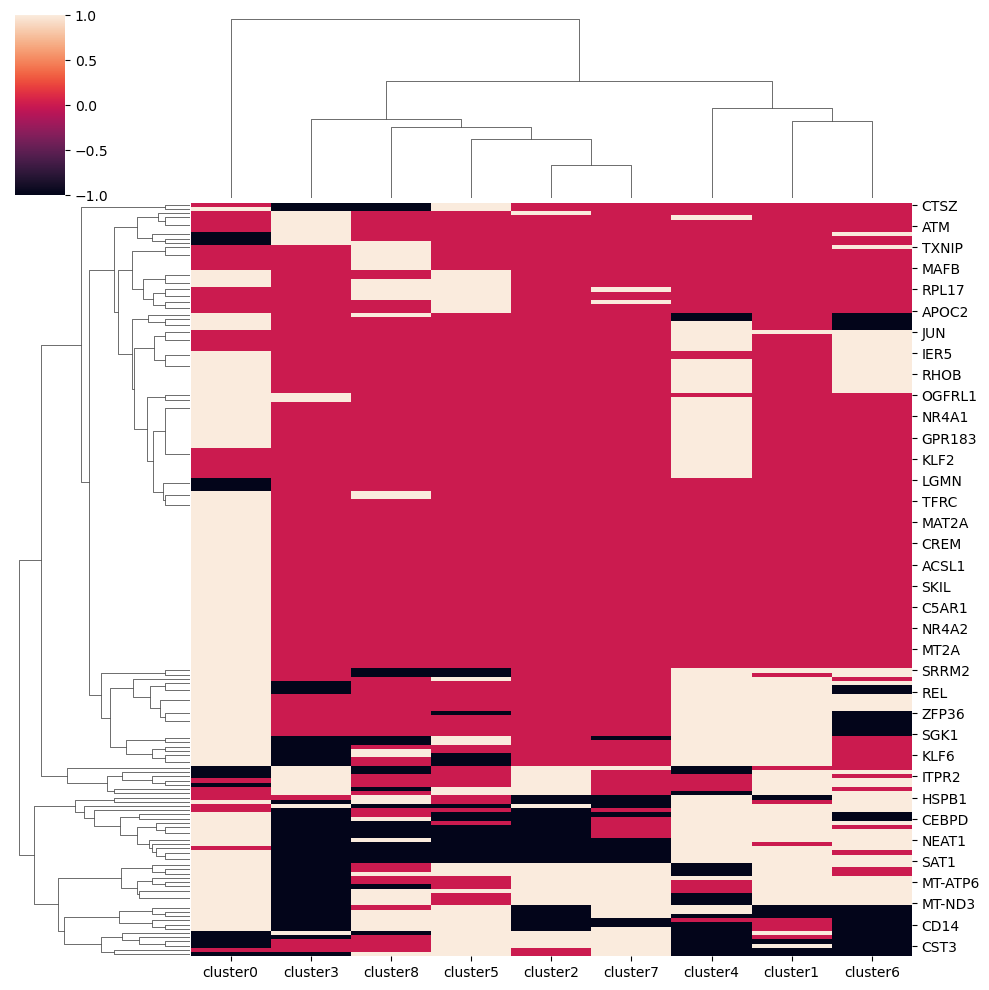

In [219]:
sns.clustermap(tri_df, metric = 'hamming')

In [220]:
tri_df.to_csv('./diffExpNew/upDownSummary_sc.csv')

# Try pseudotime calculation

Text(0.5, 0, 'DC3')

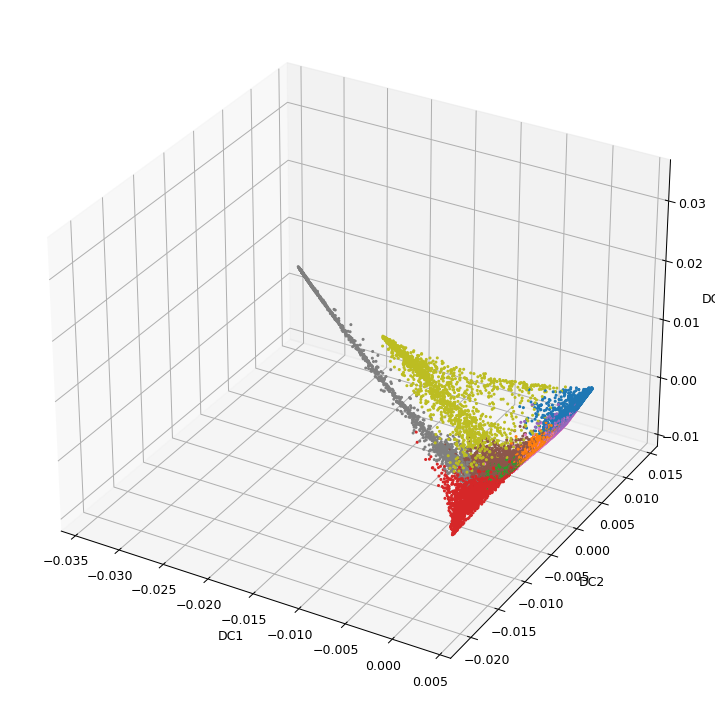

In [221]:
#sanity test to make sure the correct connectivity matrix is stored
dMap = data.obsm['X_diffmap']
col = [f'C{i}' for i in data.obs['leiden'].tolist()]
d1=1
d2=d1+1
d3=d2+1
fig = plt.figure(figsize=(12,10), dpi=90)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dMap[:,d1], dMap[:,d2], dMap[:,d3],cmap='viridis', s=2,c=col, alpha =1)
#ax.scatter(np.log10(dMap[:,d1]), np.log10(dMap[:,d2]), np.log10(dMap[:,d3]),cmap='viridis', s=2, alpha =1)

ax.set_xlabel(f'DC{d1}')
ax.set_ylabel(f'DC{d2}')
ax.set_zlabel(f'DC{d3}')

In [39]:
eVals = data.uns['diffmap_evals']

In [146]:
scp.tl.dpt(data)

In [60]:
ind_root = data.uns['iroot']
coef = eVals[1:6]/(1 - eVals[1:6])
coef = np.square(coef)
A = dMap[ind_root,1:6] -dMap[:,1:6]
A = np.square(A)
A = A * coef
dpt = A.sum(axis = 1)
dpt = dpt/dpt.max()

In [62]:
data.obs['dpt_pseudotime'] = dpt

In [322]:
# looks good to me! 
data.write_h5ad('./data_8_25_23.h5ad')